In [1]:
# Import everything that you use here. The only packages allowed are from bm-336546
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

# Part I: Loss minimization with gradient descent

In [2]:
def Loss(w1 ,w2 ,lmbda=0):
    L = -10*(0.4*np.cos(w1)-(w1**2) -0.2*(w2**7) +np.sin(w2))*np.exp(-(w1**2 + w2**2)) + (w1**2 + w2**2)*lmbda
    dldw1 = -10*np.exp(-(w1**2 + w2**2))*(-0.4*np.sin(w1)-2*w1+(0.4*np.cos(w1)-(w1**2)-0.2*(w2**7)+np.sin(w2))*(-2*w1)) +2*lmbda*w1
    dldw2 = -10*np.exp(-(w1**2 + w2**2))*(-1.4*(w2**6)+np.cos(w2)+(0.4*np.cos(w1)-(w1**2)-0.2*(w2**7)+np.sin(w2))*(-2*w2)) +2*lmbda*w2
    grad = (dldw1,dldw2)
    return L,grad

In [33]:
def grad_desc(w01 ,w02 ,step_size,lmbda=0,scatter=False):
    """
    Gradient descent will stop for the first of : number of iteration=300, L2 norm difference in weights between iterations is less than 10^-4.
    :param w01,w01 - initial weights.
    :param step_size - step size of each iteration
    :param lmbda - Regularization term coefficient
    :param scatter - Boolean parameter to decide whether to plot a scatter plot or not.
    :return A loss vs iterations plot (or scatter) and the optimal loss and weights vector.
    """
    max_iter=300
    w1 ,w2 = w01,w02
    loss=[]
    iter=[]
    current_loss = 0
    for i in range(max_iter):
        w1_curr, w2_curr = w1,w2
        current_loss ,grad = Loss(w1,w2,lmbda)
        w1-=np.multiply(step_size,grad[0])
        w2-=np.multiply(step_size,grad[1])
        if np.linalg.norm((w1_curr-w1 ,w2_curr-w2))< 10e-4 :
            iter.append(i)
            loss.append(current_loss)
            break
        iter.append(i)
        loss.append(current_loss)
    if lmbda==0:
        print('Initial weights W0=({:.3f},{:.3f}), Learning Rate {}, Optimal Weights are: W=({:.3f},{:.3f}, The loss value with the optimal weights is: {:.5f})'.format(w01,w02,step_size,w1,w2,current_loss))
    else:
        print('Initial weights W0=({:.3f},{:.3f}), Learning Rate {}, Optimal Weights W=({:.3f},{:.3f}) (L2 regularization term with lmbda={}, The loss value with the optimal weights is: {:.5f})'.format(w01, w02, step_size, w1, w2, lmbda, current_loss))
    plt.figure(figsize=(5,5))
    plt.title('Loss Vs Number of iterations')
    plt.xlabel('Num of Iterations')
    plt.ylabel('Loss Value')
    plt.plot(iter,loss) if not scatter else plt.scatter(iter,loss)

4
Initial weights W0=(1.000,1.000), Learning Rate 0.001, Optimal Weights are: W=(0.022,0.519, The loss value with the optimal weights is: -6.82030)
Initial weights W0=(0.000,-2.200), Learning Rate 0.001, Optimal Weights are: W=(0.000,-1.952, The loss value with the optimal weights is: -4.66399)
Initial weights W0=(1.000,1.000), Learning Rate 0.1, Optimal Weights are: W=(0.491,0.477, The loss value with the optimal weights is: -4.21649)
Initial weights W0=(2.000,2.000), Learning Rate 0.001, Optimal Weights are: W=(2.000,2.000, The loss value with the optimal weights is: 0.09680)


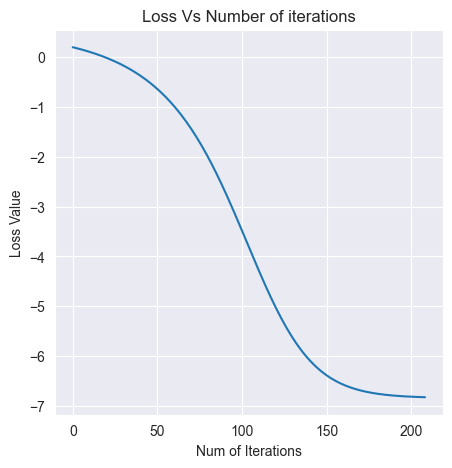

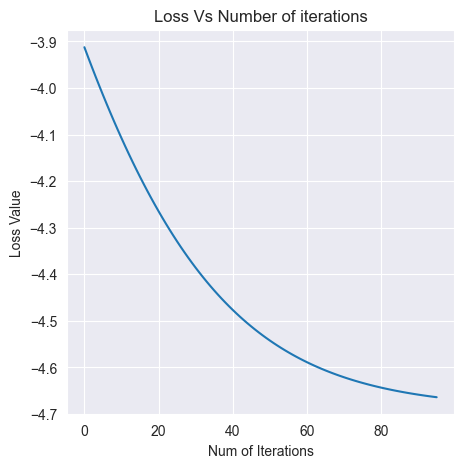

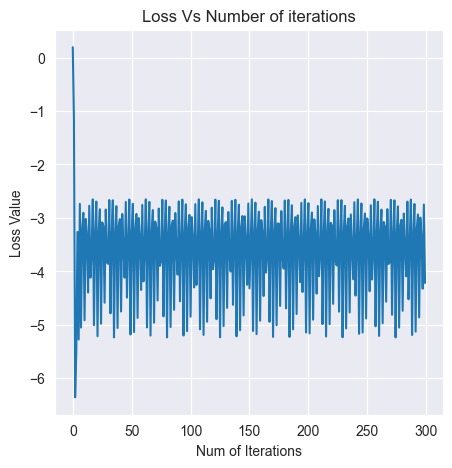

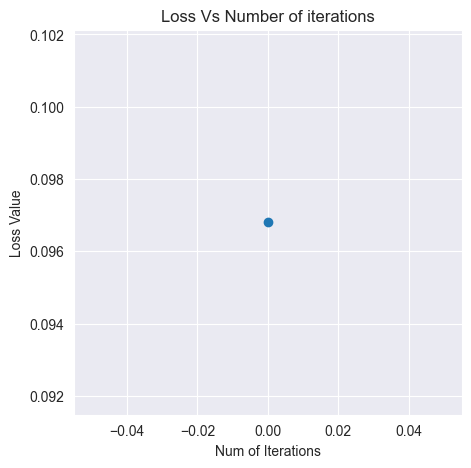

In [35]:
w1=[1,0,1,2]
w2=[1,-2.2,1,2]
steps=[0.001,0.001,0.1,0.001]
print(len(steps))
for i, step in enumerate(steps):
    grad_desc(w1[i],w2[i],step) if i!=len(steps)-1 else grad_desc(w1[i],w2[i],step,scatter=True)
#     # plt.savefig('Loss_Vs_Iter_{}.svg'.format(i))

Initial weights W0=(1.000,1.000), Learning Rate 0.001, Optimal Weights W=(0.021,0.518) (L2 regularization term with lmbda=0.01, The loss value with the optimal weights is: -6.81841)
Initial weights W0=(1.000,1.000), Learning Rate 0.001, Optimal Weights W=(0.002,0.051) (L2 regularization term with lmbda=100, The loss value with the optimal weights is: -4.23689)


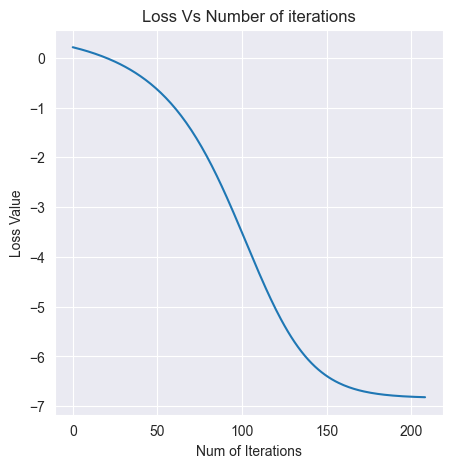

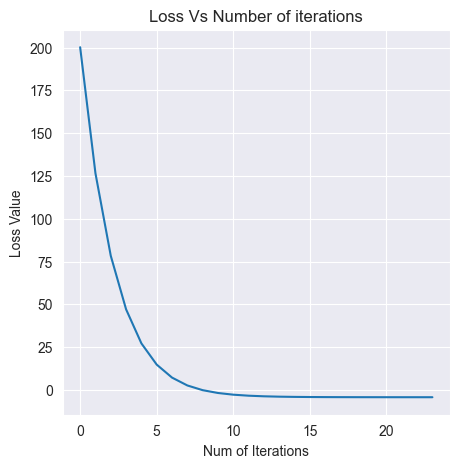

In [5]:
w1=1
w2=1
step=0.001
lmbdas=[0.01,100]
for i,lmbda in enumerate(lmbdas):
    grad_desc(w1,w2,step,lmbda)
    plt.savefig('Loss_Vs_Iter_Regularized_{}.svg'.format(i))

# Part II: Linear vs. nonliner classifiers

In [6]:
X = pd.read_csv('X_data.csv')
X.drop(columns=X.columns[0], axis=1, inplace=True)
X.head()

,Age,Systolic_BP,Diastolic_BP,Cholesterol
0,77.196340,85.288742,80.021878,79.957109
1,63.529850,99.379736,84.852361,110.382411
2,69.003986,111.349455,109.850616,100.828246
3,82.638210,95.056128,79.666851,87.066303
4,78.346286,109.154591,90.713220,92.511770


In [7]:
y = pd.read_csv('y_data.csv')  # read and convert to numpy
y.drop(columns=y.columns[0], axis=1, inplace=True)
y.head()

,y
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


#Data Preprocess
First we'll check if there's a non-numeric values in the data:

In [8]:
flag=True
data = [X,y]
for df in data:
    numeric_df = df.select_dtypes(include=['int', 'float'])
    if df.equals(numeric_df):
        continue
    else:
        flag=False
        break
print('The data contain numeric values only') if flag else print('The data contain non-numeric values')

The data contain numeric values only


We will now check to see if there is a sample that repeats itself in the data. This is also the 'new' preprocess method we think is relevant that we found in the literature.

In [9]:
duplicated = X.duplicated().any()
print('There are no duplications in the samples') if not duplicated else print('There are duplications in the samples')

There are no duplications in the samples


In [10]:
z = np.array([0,1,2,3,4,5])
sig = 1./(1+np.exp(z))
print(sig)

[0.5        0.26894142 0.11920292 0.04742587 0.01798621 0.00669285]


Since there are no duplications in the samples, we will continue our preprocessing.
We will now round the values for the features BP (Systolic and Diastolic) and Cholesterol such that it will have 2 decimals places (Based on standard measuring equipment); Age will have 2 decimal place as well, as having 8 decimal places for age is not relevant.

In [11]:
X.loc[:,'Age':'Cholesterol']=X.loc[:,'Age':'Cholesterol'].round(decimals=2)
X.head()

,Age,Systolic_BP,Diastolic_BP,Cholesterol
0,77.20,85.29,80.02,79.96
1,63.53,99.38,84.85,110.38
2,69.00,111.35,109.85,100.83
3,82.64,95.06,79.67,87.07
4,78.35,109.15,90.71,92.51


We will now proceed to clean outliers in the data. First, we will present a visualization of outliers existence using boxplot.


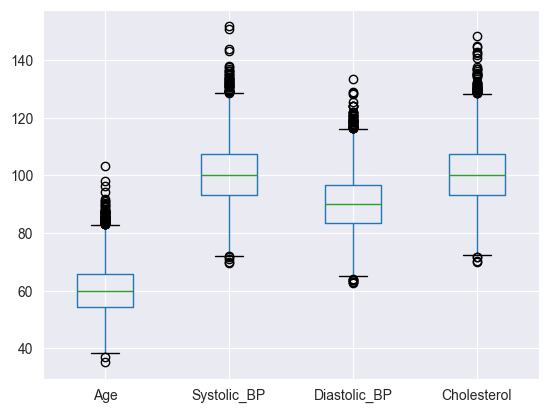

In [12]:
X.boxplot(column=['Age','Systolic_BP','Diastolic_BP','Cholesterol'])
plt.show()

Firstly, we can see that the values range of each feature are 'normal' (for example there are no negative values)
Also, there are a lot of outliers in the data. Outliers existence can affect the scaling process and thus how well our model will learn. (The effect on the learning process depends on the model type, e.g. RFC is less sensitive to outliers than SVM)

In [13]:
def remove_outlier(X,y):
    """
    :param X: Dataframe containing the samples
    :param y: Dataframe containing the labels
    :return X_new,y_new: New X,y dataframes With NaN replacing the outliers
    """
    X_new = X.copy()
    y_new = y.copy()
    for feat in X_new:
        q3 = np.percentile(X_new[feat],75)
        q1 =  np.percentile(X_new[feat],25)
        iqr = q3-q1
        for idx, val in enumerate(X_new[feat]):
            if val>q3 + (1.5*iqr) or val<q1 - (1.5*iqr):
                X_new[feat][idx] = np.nan
                y_new.iloc[idx] = np.nan
    return X_new,y_new


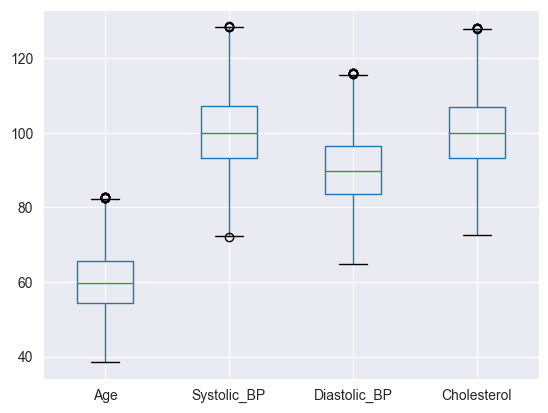

In [14]:
X_no_outlier, y_no_outlier = remove_outlier(X,y)
X_no_outlier.boxplot(column=['Age','Systolic_BP','Diastolic_BP','Cholesterol'])
plt.show()

After cleaning outliers we can see that all ranges of the four features are physiological, so we won't add another filter base on prior physiological knowledge.
Now we'd like to know how many outliers were cleaned from the dataset:

In [15]:
print('The number of outliers that were cleaned in the process is:' ,int(pd.DataFrame.count(y)-pd.DataFrame.count(y_no_outlier.dropna())))

The number of outliers that were cleaned in the process is: 214


214 samples were cleaned in the process, that's about 3.6% of the whole data. In our opinion it's reasonable, as the existence of those outliers in the data could affect the scaling process we will do in the training section.

In [16]:
#Dropping the NaNs and combining X,y to one dataframe:
X_no_outlier=X_no_outlier.dropna()
y_no_outlier=y_no_outlier.dropna()
df = X_no_outlier.copy()
df['label'] = y_no_outlier
df.loc[df['label']==1,'label'] = 'DR'
df.loc[df['label']==0,'label'] = 'No DR'
df.head()

,Age,Systolic_BP,Diastolic_BP,Cholesterol,label
0,77.20,85.29,80.02,79.96,DR
1,63.53,99.38,84.85,110.38,DR
2,69.00,111.35,109.85,100.83,DR
3,82.64,95.06,79.67,87.07,DR
4,78.35,109.15,90.71,92.51,DR


Next, we would like to see the relationship between features and labels. For that, we'll use sea born pair plot:

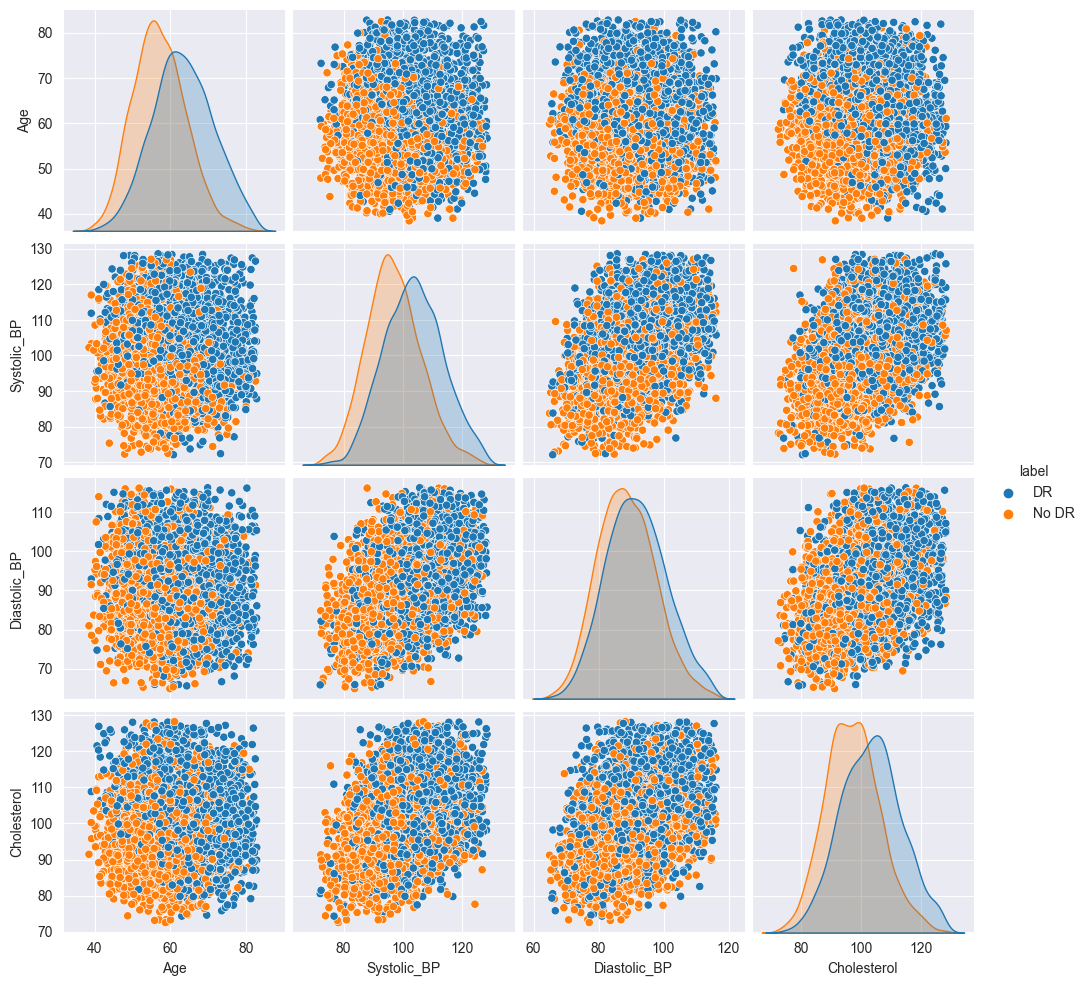

In [17]:
sns.pairplot(df.loc[:,'Age':'label'], hue="label");

Here we can see a matrix of scatter plots, in which every graph is a scatter plot of 2 features and their labels. On the diagonal there's the distribution of a specific feature for each label. As we can see, the features are hardly separated. There is a large portion of the samples that mixed with one another, but there are portions that have mainly blue or orange dots (generally on the top right or bottom left values which are the edge values). To understand better the distribution of the features and their labels, we'll use kde plot (kernel distribution estimation):

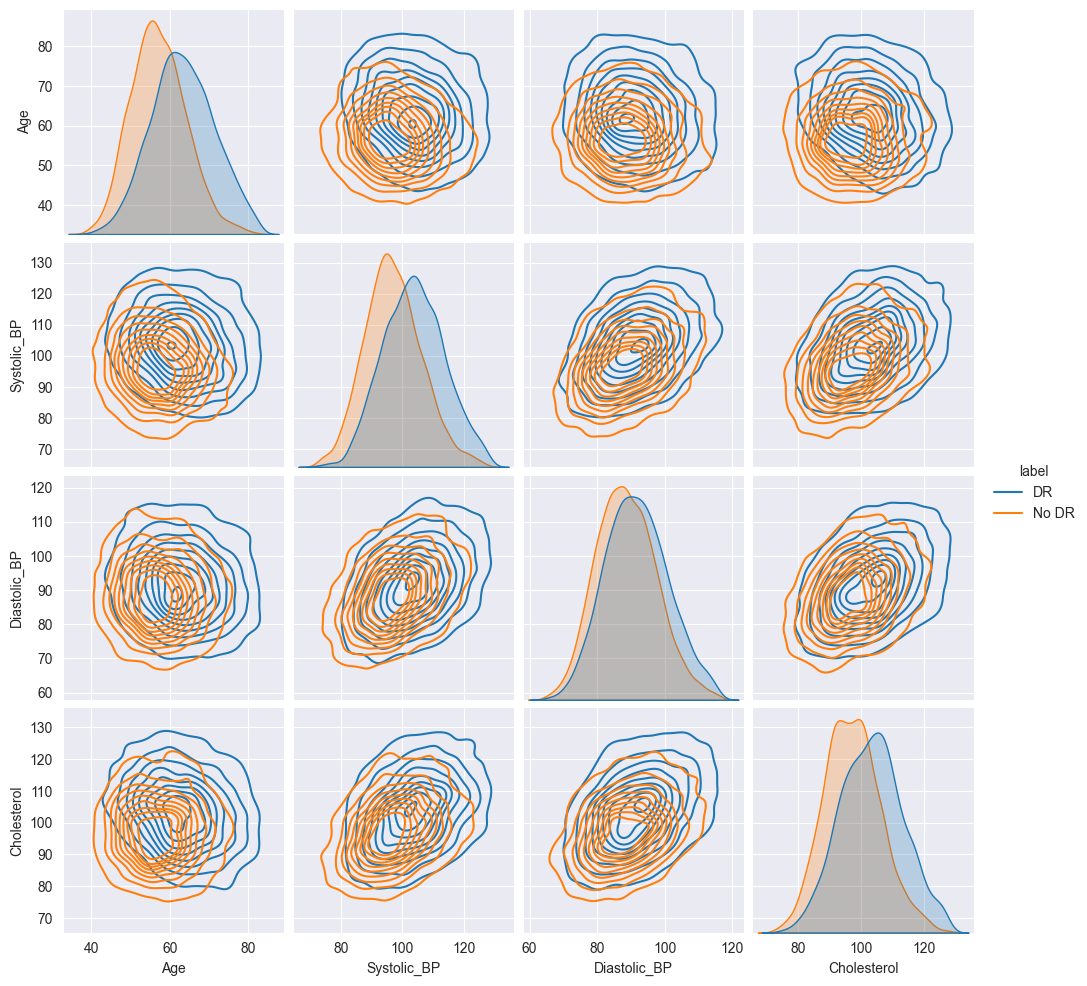

In [18]:
sns.pairplot(df.loc[:,'Age':'label'],hue='label', kind="kde")

Here, every graph shows us the estimated 2d distribution of the features for each label. As we can see, the distribution overlaps in the majority of the area, which strengthen our claim that the data is hardly separated. With that being said, we can also see that the 'Age' feature has the most separated distribution compared to other features, so we would assume it is particularly important for our model (It also makes physiological sense and is backed up by this reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8213493/). Furthermore, we would say that BP (Specifically Systolic) is also important for our model for the same reasons.
We will now proceed to the stratified train-test split and talk about question 2.a

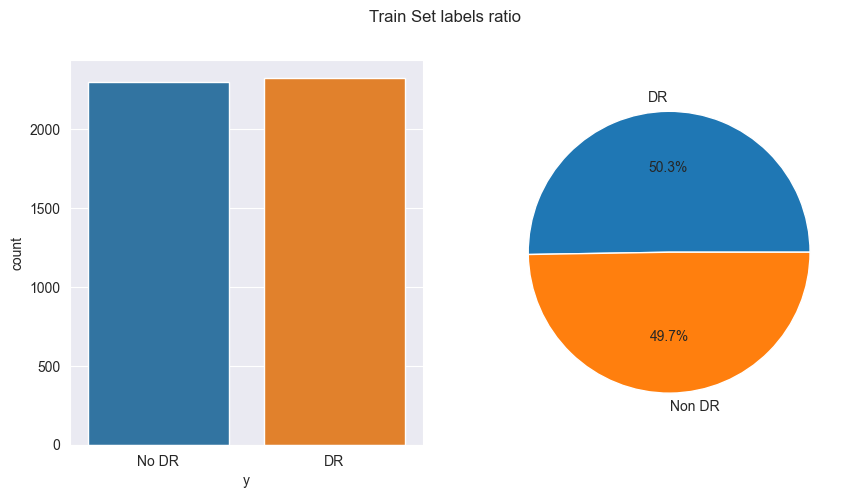

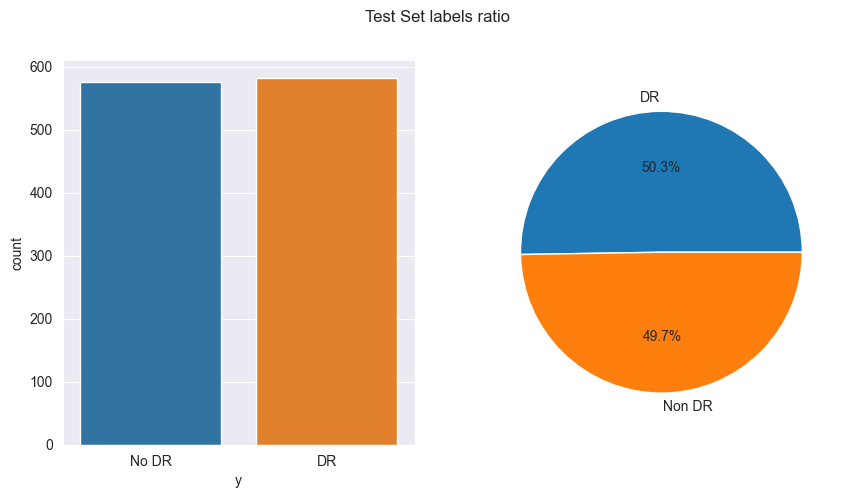

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_no_outlier, y_no_outlier, test_size=0.2,
                                                    random_state=336546, stratify=y_no_outlier)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.ravel()
plt.suptitle('Train Set labels ratio')
y_train.value_counts().plot(kind="pie", labels=['DR','Non DR'], autopct='%1.1f%%',ax=axes[1])
g = sns.countplot(x='y',data = y_train, ax=axes[0])
g.set(xticklabels=['No DR','DR'])

plt.show()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.ravel()
plt.suptitle('Test Set labels ratio')
y_test.value_counts().plot(kind="pie", labels=['DR','Non DR'], autopct='%1.1f%%',ax=axes[1])
g = sns.countplot(x='y',data = y_test, ax=axes[0])
g.set(xticklabels=['No DR','DR'])
plt.show()

#(Answering question 2.a.1): We can see there is almost a perfect balance between the classes (labels), both in Train and Test sets. This is very convenient, as in 'real life' this scenario is quite rare. In reality, our data will be mostly imbalanced, in a way that our model will learn more from the 'majority' class and less from the 'minority' class, which will cause bias in the model. To deal with these issues, there are few tactics; One of them is changing the performance metrics. Instead of looking at 'Accuracy' alone, which declares how accurate our model is, we can look at other statistics that will give us a better understanding on how 'well' our model is doing. These statistics include: Confusion matrix (A table that showing the amount of correct predictions along the amount of incorrect predictions and their types (False negative, False positive)), Precision (The ratio between True Positive and all positive predictions) and sensitivity (The ratio between False positive predictions and all false predictions) and so on. By tuning our hyperparameters based on these statistics, we can get results that are satisfying enough for our application, even if the data is imbalanced.
#(Answering question 2.a.2): Labels imbalance between train and test is a different case. We would like both of the sets to have the same 'conditions' (As the reason we scale our data for example), so we could really test our model with weights relevant to the test dataset. Training and evaluating on uneven proportions of labels will lead to predictions errors, while the solution is simple. All we need to do is perform *Stratified* Test-Train Split, which means we force our split to have the same proportions in labels between the Train and Test sets.

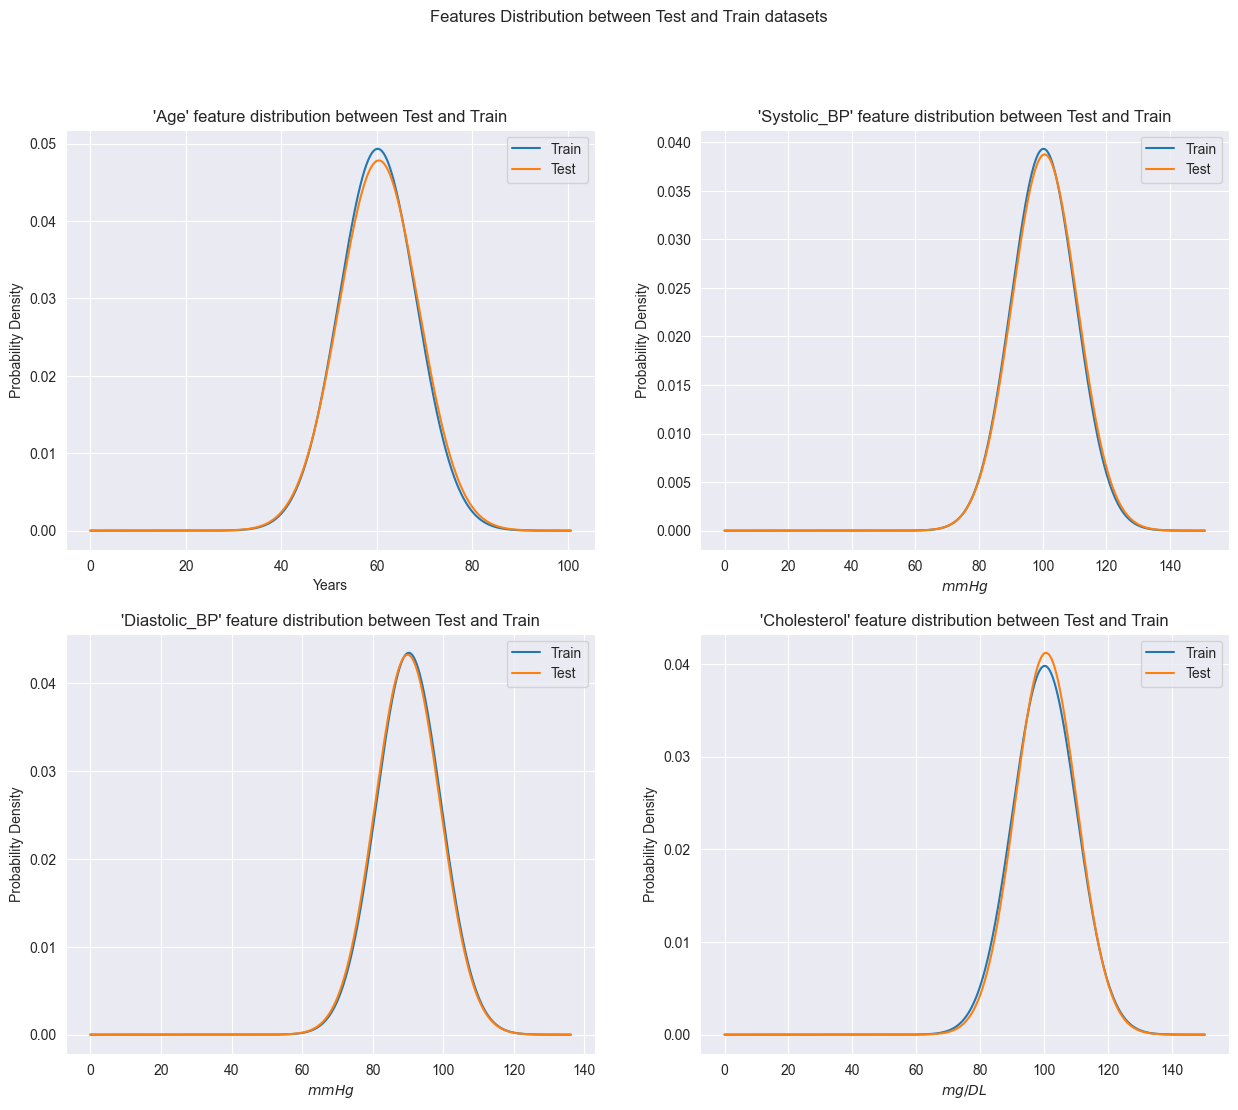

In [20]:
train_stat = {feat: {'Mean': np.mean(X_train[feat]),'std':np.std(X_train[feat])} for feat in X_train}
test_stat = {feat: {'Mean': np.mean(X_test[feat]),'std':np.std(X_test[feat])} for feat in X_test}
fig, axes = plt.subplots(2,2,figsize=(15,12))
plt.suptitle('Features Distribution between Test and Train datasets')
axes=axes.ravel()
labels=['Years','$mmHg$','$mmHg$','$mg/DL$']
for idx,feat in enumerate(X_train):
    mean_train = train_stat[feat]['Mean']
    std_train = train_stat[feat]['std']
    mean_test = test_stat[feat]['Mean']
    std_test = test_stat[feat]['std']
    x = np.linspace(0, mean_train + 5 * std_train, 1000)
    axes[idx].plot(x,stats.norm.pdf(x, mean_train, std_train),label='Train')
    axes[idx].plot(x,stats.norm.pdf(x, mean_test, std_test),label='Test')
    axes[idx].set_title("'{}' feature distribution between Test and Train".format(feat))
    axes[idx].set_xlabel(labels[idx])
    axes[idx].set_ylabel('Probability Density')
    axes[idx].legend()
plt.show()

From those graphs, we can see that the feature distribution is similar between the test and train sets.

In [21]:
n_splits=5
skf = StratifiedKFold(n_splits=n_splits, random_state=336546, shuffle=True)

In [22]:
#Logistic Regression:
log_reg = LogisticRegression(random_state=336546,solver='saga')
scaler = StandardScaler()
pipe_lr = Pipeline([('scaler', scaler), ('lr', log_reg)])

param_grid = {'lr__C': [0.01, 0.1, 1, 10, 100], 'lr__penalty': ['l1', 'l2']}

log_reg_grid = GridSearchCV(pipe_lr, param_grid, cv=skf,scoring='roc_auc',refit='True',verbose=3)

log_reg_grid.fit(X_train, y_train.values.ravel())
best_log_reg = log_reg_grid.best_estimator_
print('Best hyperparameters for Logistic Regression:' ,log_reg_grid.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ........lr__C=0.01, lr__penalty=l1;, score=0.820 total time=   0.0s
[CV 2/5] END ........lr__C=0.01, lr__penalty=l1;, score=0.828 total time=   0.0s
[CV 3/5] END ........lr__C=0.01, lr__penalty=l1;, score=0.824 total time=   0.0s
[CV 4/5] END ........lr__C=0.01, lr__penalty=l1;, score=0.815 total time=   0.0s
[CV 5/5] END ........lr__C=0.01, lr__penalty=l1;, score=0.832 total time=   0.0s
[CV 1/5] END ........lr__C=0.01, lr__penalty=l2;, score=0.820 total time=   0.0s
[CV 2/5] END ........lr__C=0.01, lr__penalty=l2;, score=0.828 total time=   0.0s
[CV 3/5] END ........lr__C=0.01, lr__penalty=l2;, score=0.824 total time=   0.0s
[CV 4/5] END ........lr__C=0.01, lr__penalty=l2;, score=0.814 total time=   0.0s
[CV 5/5] END ........lr__C=0.01, lr__penalty=l2;, score=0.832 total time=   0.0s
[CV 1/5] END .........lr__C=0.1, lr__penalty=l1;, score=0.820 total time=   0.0s
[CV 2/5] END .........lr__C=0.1, lr__penalty=l1;

In [23]:
#SVM:
svc = SVC(probability=True)
pipe_svm = Pipeline([('scaler', scaler), ('svm', svc)])

param_grid = {'svm__C': [0.1, 1], 'svm__kernel': ['linear', 'rbf', 'poly']}

svm_grid = GridSearchCV(pipe_svm, param_grid, cv=skf, scoring='roc_auc', refit='True',verbose=3)

svm_grid.fit(X_train, y_train.values.ravel())

best_svm = svm_grid.best_estimator_

print('Best hyperparameters for SVM are:' , svm_grid.best_params_)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....svm__C=0.1, svm__kernel=linear;, score=0.820 total time=   0.8s
[CV 2/5] END ....svm__C=0.1, svm__kernel=linear;, score=0.828 total time=   0.8s
[CV 3/5] END ....svm__C=0.1, svm__kernel=linear;, score=0.824 total time=   0.8s
[CV 4/5] END ....svm__C=0.1, svm__kernel=linear;, score=0.814 total time=   0.7s
[CV 5/5] END ....svm__C=0.1, svm__kernel=linear;, score=0.832 total time=   0.8s
[CV 1/5] END .......svm__C=0.1, svm__kernel=rbf;, score=0.814 total time=   1.5s
[CV 2/5] END .......svm__C=0.1, svm__kernel=rbf;, score=0.824 total time=   1.5s
[CV 3/5] END .......svm__C=0.1, svm__kernel=rbf;, score=0.828 total time=   1.5s
[CV 4/5] END .......svm__C=0.1, svm__kernel=rbf;, score=0.817 total time=   1.5s
[CV 5/5] END .......svm__C=0.1, svm__kernel=rbf;, score=0.831 total time=   1.5s
[CV 1/5] END ......svm__C=0.1, svm__kernel=poly;, score=0.808 total time=   0.9s
[CV 2/5] END ......svm__C=0.1, svm__kernel=poly;,

In [24]:
#Random Forest:
rfc = RandomForestClassifier()
pipe_rfc = Pipeline([('scaler', scaler), ('rfc', rfc)])

param_grid = {'rfc__criterion': ['gini', 'entropy'], 'rfc__max_depth': [2, 4, 6, 8], 'rfc__max_features': ['sqrt', 'log2']}

rfc_grid = GridSearchCV(pipe_rfc, param_grid, cv=skf, scoring='roc_auc', refit='True',verbose=3)

rfc_grid.fit(X_train, y_train.values.ravel())

best_rfc = rfc_grid.best_estimator_

print('Best hyperparameters for RFC are:' , rfc_grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END rfc__criterion=gini, rfc__max_depth=2, rfc__max_features=sqrt;, score=0.799 total time=   0.1s
[CV 2/5] END rfc__criterion=gini, rfc__max_depth=2, rfc__max_features=sqrt;, score=0.804 total time=   0.1s
[CV 3/5] END rfc__criterion=gini, rfc__max_depth=2, rfc__max_features=sqrt;, score=0.809 total time=   0.1s
[CV 4/5] END rfc__criterion=gini, rfc__max_depth=2, rfc__max_features=sqrt;, score=0.805 total time=   0.1s
[CV 5/5] END rfc__criterion=gini, rfc__max_depth=2, rfc__max_features=sqrt;, score=0.824 total time=   0.1s
[CV 1/5] END rfc__criterion=gini, rfc__max_depth=2, rfc__max_features=log2;, score=0.800 total time=   0.1s
[CV 2/5] END rfc__criterion=gini, rfc__max_depth=2, rfc__max_features=log2;, score=0.806 total time=   0.1s
[CV 3/5] END rfc__criterion=gini, rfc__max_depth=2, rfc__max_features=log2;, score=0.807 total time=   0.1s
[CV 4/5] END rfc__criterion=gini, rfc__max_depth=2, rfc__max_features=log2;

In [25]:
models = ['Logistic Regression','SVM','RFC']
estimators = [best_log_reg,best_svm,best_rfc]
for i,estimator in enumerate(estimators):
    y_pred = estimator.predict(X_test)
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    print(f'{models[i]}:\n AUC Score: {auc:.3f}, F1 Score: {f1:.3f}, Accuracy Score: {acc:.3f}')

Logistic Regression:
 AUC Score: 0.717, F1 Score: 0.720, Accuracy Score: 0.717
SVM:
 AUC Score: 0.719, F1 Score: 0.724, Accuracy Score: 0.719
RFC:
 AUC Score: 0.717, F1 Score: 0.726, Accuracy Score: 0.717


We can see that all the models performed about the same on the test set. RFC has the best F1 score, while SVM has the best AUC and Accuracy scores, but the differences are extreme subtle. So in terms of F1 score, the non-linear model performed better, while SVM (Notice that's a *linear* SVM, as the linear kernel was chosen by the gridsearch) has AUC and ACC scores of 0.002 higher than the non-linear model (RFC). LR isn't leading in any of the metrics. Overall, we'd say that RFC performed best, by a small margin compared to SVM.
A naive classifier would have gotten an accuracy score of 0.503, so obviously we can say that our estimators performed better, but not by a great margin.

In [26]:
#Section 4
y_pred_test = best_rfc.predict(X_test)
y_pred_train = best_rfc.predict(X_train)

predictions = [y_pred_train, y_pred_test]
y_sets = [y_train, y_test]
sets = ['Train', 'Test']
for i, pred in enumerate(predictions):
    auc = roc_auc_score(y_sets[i],pred)
    f1 = f1_score(y_sets[i],pred)
    acc = accuracy_score(y_sets[i],pred)
    print(f'{sets[i]} Set Scores for RFC:\nAUC Score: {auc:.3f}, F1 score:{f1:.3f}, Accuracy score: {acc:.3f}')

Train Set Scores for RFC:
AUC Score: 0.783, F1 score:0.786, Accuracy score: 0.783
Test Set Scores for RFC:
AUC Score: 0.717, F1 score:0.726, Accuracy score: 0.717


We can see there's a difference between the scores of the train and test sets because naturally our model has 'seen' the train set and learned to make predictions on it. The test set exists in order to test how well our model can generalize to cases it's never seen before. In order to reduce the difference (In other words, make our model better), we need to fine the sweet spot between bias and variance. The more our model is over-fitted on the train set, there's more variance and the more our model is under-fitted, it has more bias. There are few techniques that helps find this sweet spot such as regularization (helps prevent overfitting), validation of hyperparameters (Hyperparameters define and affect the learning process so tuning them widely affect the results), and so on.

There are some major advantages of RFC over SVM, and here are few:
- RFCs are faster to train and predict compared to SVMs, especially for large datasets. That's because RFC are based on decision trees, which are faster to train and predict compared to SVM which based on complex kernels.
- RFCs are much less sensitive to noise. That's because RFC use a lot of decision trees which are trained on randomly generated data from the training data ('Bagging' process), and therefore are less sensitive to noise and outliers compared to SVM.
- RFCs can also handle missing values while SVMs cannot. That's because RFC can impute missing values by using values from other features, which it already normally does in the training period. In SVM, all features require a value in order to make a prediction.

We will now determine which are the two most important features according to RFC and Logistic Regression models.

In [27]:
# Logistic Regression:
lr_weights = best_log_reg.named_steps['lr'].coef_[0]
sorted_idx = lr_weights.argsort()[::-1]
print(f"According to LR model, the most important feature is: '{X.columns[sorted_idx[0]]}' and the second most important feature is: '{X.columns[sorted_idx[1]]}'")

According to LR model, the most important feature is: 'Age' and the second most important feature is: 'Systolic_BP'


In [28]:
# RFC:
rfc_important_feat = best_rfc.named_steps['rfc'].feature_importances_
sorted_idx = rfc_important_feat.argsort()[::-1]
print(f"According to RFC model, the most important feature is: '{X.columns[sorted_idx[0]]}' and the second most important feature is: '{X.columns[sorted_idx[1]]}'")

According to RFC model, the most important feature is: 'Age' and the second most important feature is: 'Systolic_BP'


According to both LR anf RFC models, the most important feature is 'Age' and the second most important feature is 'Systolic_BP'.
This match up with the claims we made in the feature exploration part we preformed earlier, that 'Age' is a particularly important feature for our model because it has the most seperated distribution compared to other features distributions, and also 'Systolic_BP'.